In [72]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import functions as funcs
import pyemma as pm
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import numpy as np
import functions as funcs
import pymc3 as pm
import scipy as sp
import pickle

In [158]:
def fit(data, dep_var, ind_vars, formula, input_space, bayes_kws):
    # determin min/max values for scaling function
    dep_range = np.array([data[dep_var].min(), data[dep_var].max()])    
    output_space = {'dep_var': dep_range}
    var_space = input_space.copy()
    var_space.update({dep_var: output_space['dep_var']})
    
    # Create scaler
    vs = funcs.create_grid(var_space)
    vs_y, vs_X = funcs.create_dmatrices(vs, formula=formula)
    _, scaler = funcs.scale_dmatrix(pd.concat([vs_y, vs_X], axis=1), scaler=None)

    # Scale data
    y, X = funcs.create_dmatrices(data, formula=formula)
    data_s, _ = funcs.scale_dmatrix(pd.concat([y, X], axis=1), scaler=scaler)
    # GP data and priors
    dep_var_cols = [x for x in data_s.columns if dep_var in x]
    ind_var_cols = [x for x in data_s.columns if np.any([y in x for y in ind_vars])]
    y =  data_s.loc[:, dep_var_cols]
    X =  data_s.loc[:, ind_var_cols]
    l_prior = funcs.gamma(2, 0.5)
    eta_prior = funcs.hcauchy(2)
    sigma_prior = funcs.hcauchy(2)
    
    
    gp, trace, model = funcs.fit_gp(y=y, X=X,  # Data
                                    l_prior=l_prior, eta_prior=eta_prior, sigma_prior=sigma_prior,  # Priors
                                    kernel_type='exponential',  # Kernel
                                    prop_Xu=None,  # proportion of data points which are inducing variables.
                                    bayes_kws=bayes_kws)  # Bayes kws

    results = {'gp': gp, 'trace': trace, 'model': model, 'data': data}
    return results


def get_data(data_sets, dep_var, ind_vars, protein, feature, num_its=None, transform=None):
    
    data = data_sets[dep_var].copy()
    ix = (data.protein==protein) & (data.feature__value==feature)
    if dep_var == 'timescale':
        ix = ix & (data.num_its == num_its)
    if feature == 'distances':
        if transform is None:
            raise ValueError('For distance feature you must specify a transform')
        ix = ix & (data.distances__transform == transform)
        
    data = data.loc[ix, [dep_var]+ind_vars]
    return data
 

# Introduction

This notebook selects the most poorly performing model (in terms of the number of divergences) and will try to diagnose and fix the problem. I will be following the advice in [this PyMC3 tutorial](https://docs.pymc.io/pymc-examples/examples/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html). 

## Find diverging models

In [74]:
model_paths = Path('sensitivities_exp').glob('*.pkl')
for path in model_paths:
    result = pickle.load(path.open('rb'))
    divergent = result['trace']["diverging"]
    if divergent.nonzero()[0].size > 0:
        print(path.stem, divergent.nonzero()[0].size)

2f4k_distances_linear_timescale_its_2_sensitivity 1
cln025_dihedrals_vamp_sensitivity 3
2wav_dihedrals_timescale_its_2_sensitivity 161
prb_dihedrals_timescale_its_2_sensitivity 1
prb_distances_logistic_timescale_its_3_sensitivity 1
prb_distances_linear_timescale_its_2_sensitivity 1


In [76]:
results = pickle.load(Path('sensitivities_exp/2wav_dihedrals_timescale_its_2_sensitivity.pkl').open('rb'))

## 2wav_dihedrals_timescale_its_2_sensitivity

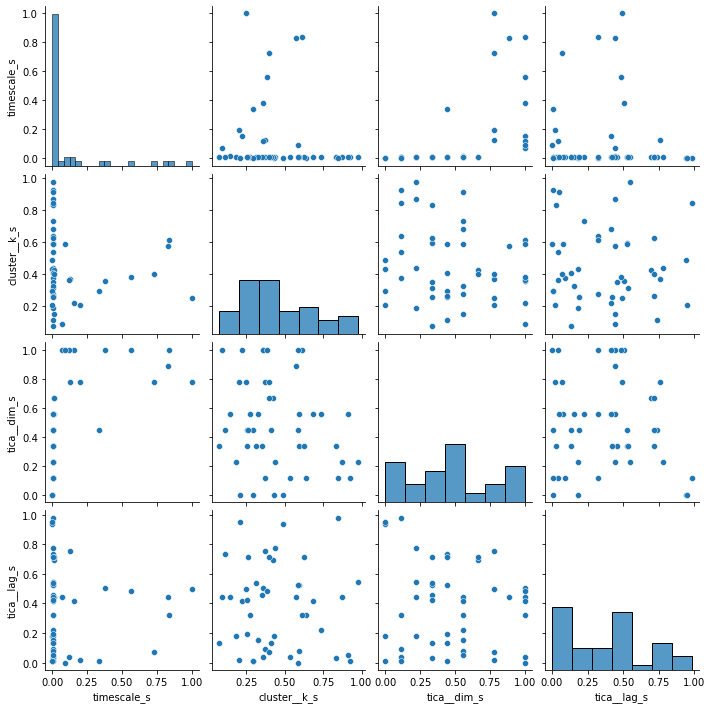

In [77]:
sns.pairplot(results['data'])

In [110]:
df = pd.read_hdf('timescales.h5')
df['feature'] = df.apply(lambda x: 'dihedrals' if x['feature__value'] == 'dihedrals' else f"{x['feature__value']}_{x['distances__transform']}", axis=1)
df = df.loc[(df.protein=='BBL') & (df.num_its <= 4), ['value', 'num_its', 'iteration','feature', 'lag',  'hp_index']]

In [111]:
ts = df.groupby(['num_its','feature', 'hp_index', 'lag'], as_index=False).median()
ts.drop(labels='iteration', axis=1, inplace=True)

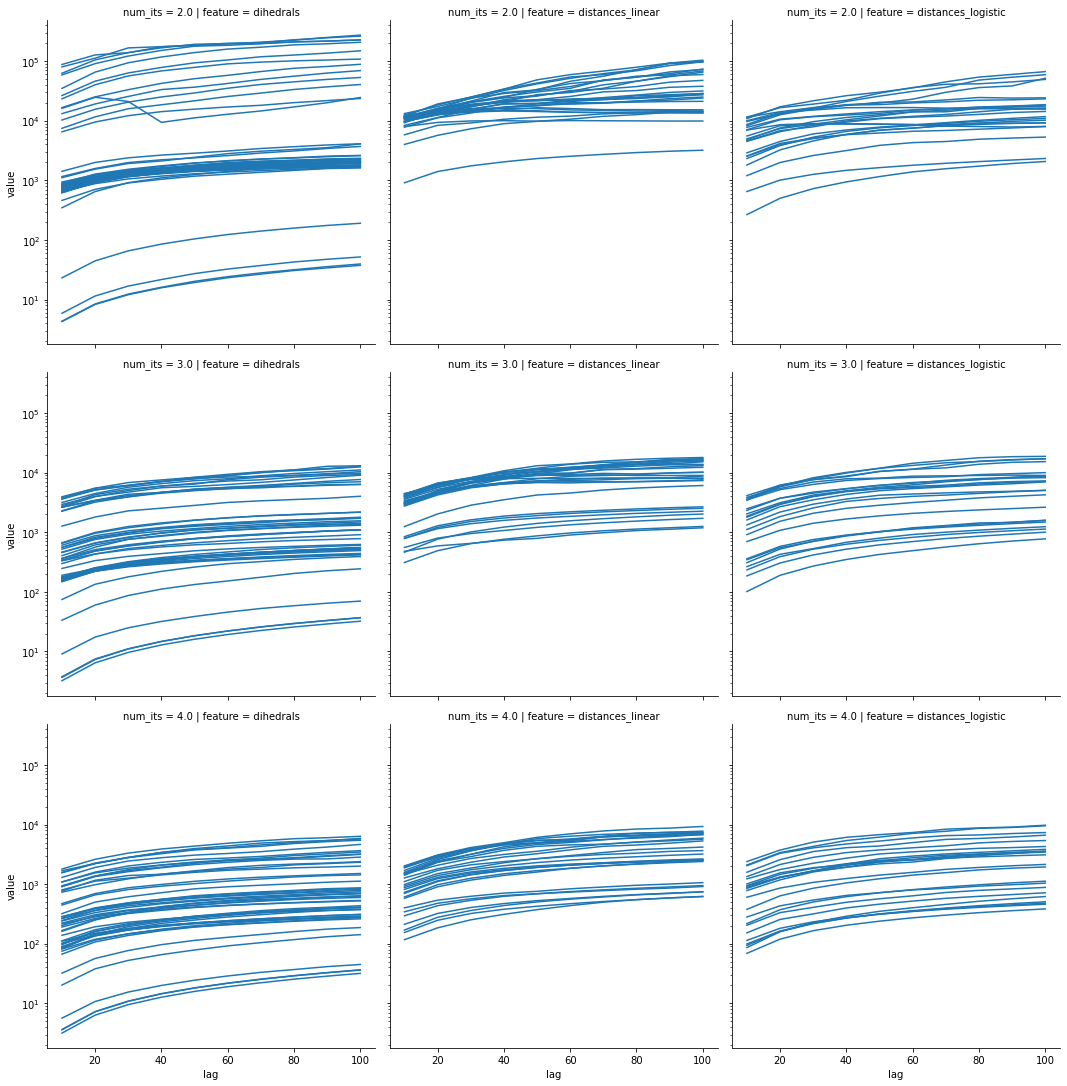

In [120]:
# g = sns.FacetGrid(ts, row='num_its', col='feature', margin_titles=True)
# g.map(sns.lineplot, 'lag', 'value')
# g.set(yscale='log')

g = sns.relplot(data=ts, x='lag', y='value', row='num_its', col='feature', units='hp_index', kind='line', estimator=None)
g.set(yscale='log')

Should try putting the t2 on a log scale

In [125]:
data = pd.read_hdf('timescales.h5')
# data['feature'] = data.apply(lambda x: 'dihedrals' if x['feature__value'] == 'dihedrals' else f"{x['feature__value']}_{x['distances__transform']}", axis=1)
data = data.loc[(data.protein=='BBL') & (data.num_its == 2) & (data.lag==30) & (data.feature__value=='dihedrals'), :]
data.head()

,value,lag,num_its,iteration,cluster__k,cluster__max_iter,cluster__stride,dihedrals__which,distances__centre,distances__scheme,distances__steepness,distances__transform,feature__value,tica__dim,tica__lag,tica__stride,hp_index,protein
20,31914.533649,30.0,2.0,0.0,191.0,1000.0,10.0,all,1.402167,ca,23.955992,logistic,dihedrals,8.0,76.0,10.0,0.0,BBL
120,934264.793242,30.0,2.0,1.0,191.0,1000.0,10.0,all,1.402167,ca,23.955992,logistic,dihedrals,8.0,76.0,10.0,0.0,BBL
220,1482.420711,30.0,2.0,2.0,191.0,1000.0,10.0,all,1.402167,ca,23.955992,logistic,dihedrals,8.0,76.0,10.0,0.0,BBL
320,1636.125621,30.0,2.0,3.0,191.0,1000.0,10.0,all,1.402167,ca,23.955992,logistic,dihedrals,8.0,76.0,10.0,0.0,BBL
420,1730.816199,30.0,2.0,4.0,191.0,1000.0,10.0,all,1.402167,ca,23.955992,logistic,dihedrals,8.0,76.0,10.0,0.0,BBL


In [154]:
t2  = data.groupby(['hp_index'], as_index=False)['value'].median()
t2 = t2.merge(data.loc[:, ['cluster__k', 'tica__dim', 'tica__lag', 'hp_index']].drop_duplicates(), on='hp_index', how='left')
t2.drop(labels='hp_index', axis=1,  inplace=True)
t2.head()

,value,cluster__k,tica__dim,tica__lag
0,21089.217917,191.0,8.0,76.0
1,56532.423371,154.0,5.0,2.0
2,1245.273278,273.0,2.0,5.0
3,12.339434,249.0,1.0,94.0
4,1057.434887,44.0,4.0,14.0


In [160]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

feature = 'dihedrals'
feature_label = 'dihedrals'
transform = None
ind_vars = ['cluster__k', 'tica__dim', 'tica__lag']
input_space = {'tica__lag': np.array([1, 10, 100]), 'tica__dim': np.array([1, 5, 10]), 'cluster__k': np.array([10, 250, 500]), 
              'distances__scheme': np.array(['ca', 'closest-heavy'])}


dep_var = list(t2.columns)[0]
ind_vars = list(t2.columns)[1:]

formula = f"np.log({dep_var}) ~ 0 + " + ' + '.join(ind_vars)
new_results = fit(t2, dep_var, ind_vars, formula, input_space, bayes_kws=dict(draws=2000, tune=3000, chains=4, cores=4, target_accept=0.90))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_n, l_tica__lag_s, l_tica__dim_s, l_cluster__k_s, eta]


INFO (theano.gof.compilelock): Waiting for existing lock by process '91121' (I am process '91063')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.0-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '91090' (I am process '91063')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.0-64/lock_dir
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/th

In [161]:
pm.summary(new_results['trace']).round(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
eta,0.455,0.112,0.272,0.671,0.002,0.001,3820.0,3702.0,4093.0,4290.0,1.0
l_cluster__k_s,7.280,3.404,1.799,13.615,0.043,0.031,6315.0,6222.0,6110.0,5252.0,1.0
l_tica__dim_s,0.917,0.636,0.157,2.068,0.011,0.008,3440.0,3440.0,3016.0,4129.0,1.0
l_tica__lag_s,4.970,2.890,0.790,10.110,0.048,0.034,3639.0,3639.0,2954.0,3088.0,1.0
sigma_n,0.060,0.020,0.019,0.097,0.000,0.000,1977.0,1977.0,2523.0,1087.0,1.0


array([[<AxesSubplot:title={'center':'eta'}>,
        <AxesSubplot:title={'center':'eta'}>],
       [<AxesSubplot:title={'center':'l_cluster__k_s'}>,
        <AxesSubplot:title={'center':'l_cluster__k_s'}>],
       [<AxesSubplot:title={'center':'l_tica__dim_s'}>,
        <AxesSubplot:title={'center':'l_tica__dim_s'}>],
       [<AxesSubplot:title={'center':'l_tica__lag_s'}>,
        <AxesSubplot:title={'center':'l_tica__lag_s'}>],
       [<AxesSubplot:title={'center':'sigma_n'}>,
        <AxesSubplot:title={'center':'sigma_n'}>]], dtype=object)

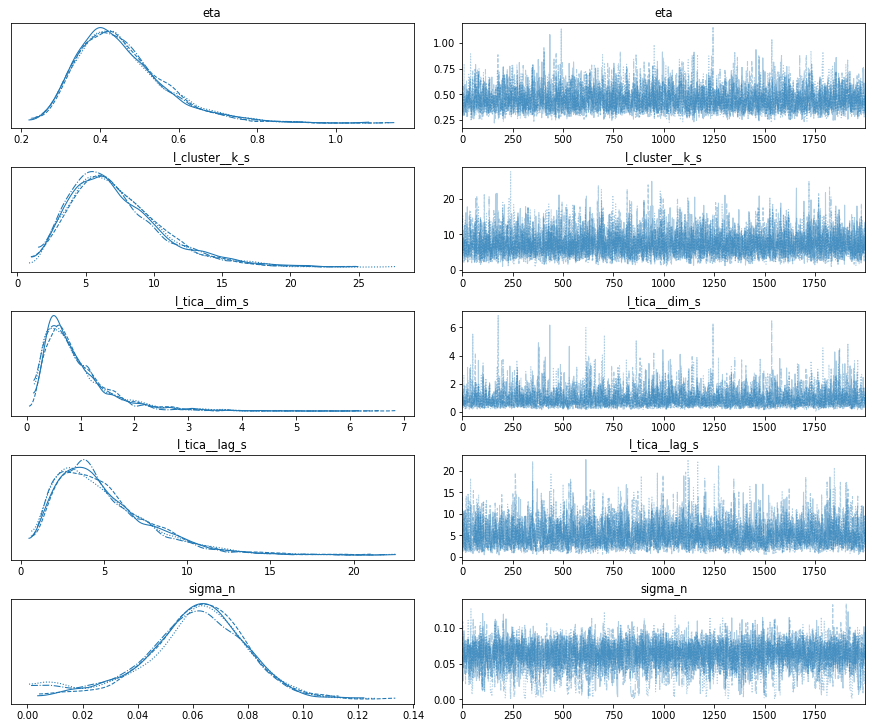

In [162]:
pm.traceplot(new_results['trace'])

## cln025_dihedrals_vamp_sensitivity

In [163]:
results = pickle.load(Path('sensitivities_exp/cln025_dihedrals_vamp_sensitivity.pkl').open('rb'))

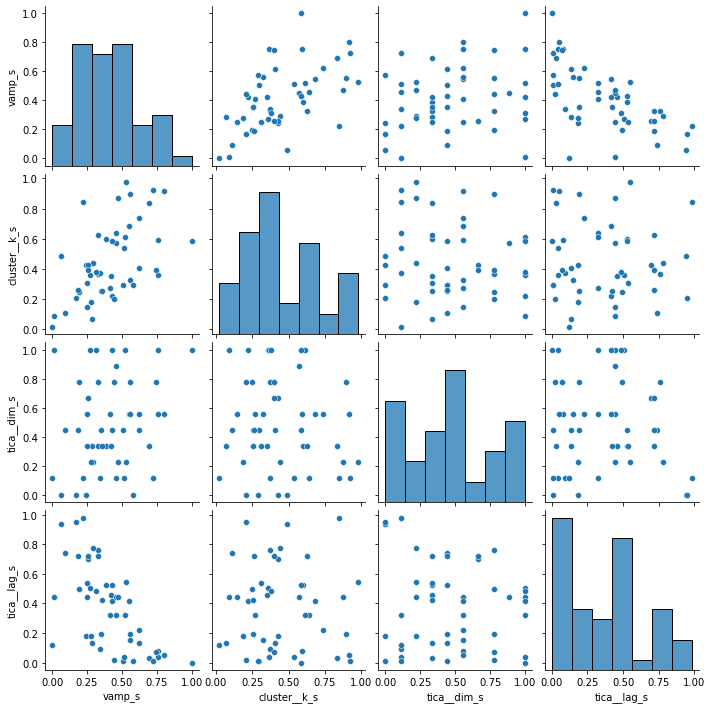

In [193]:
sns.pairplot(results['data'])

array([[<AxesSubplot:title={'center':'eta'}>,
        <AxesSubplot:title={'center':'eta'}>],
       [<AxesSubplot:title={'center':'l_cluster__k_s'}>,
        <AxesSubplot:title={'center':'l_cluster__k_s'}>],
       [<AxesSubplot:title={'center':'l_tica__dim_s'}>,
        <AxesSubplot:title={'center':'l_tica__dim_s'}>],
       [<AxesSubplot:title={'center':'l_tica__lag_s'}>,
        <AxesSubplot:title={'center':'l_tica__lag_s'}>],
       [<AxesSubplot:title={'center':'sigma_n'}>,
        <AxesSubplot:title={'center':'sigma_n'}>]], dtype=object)

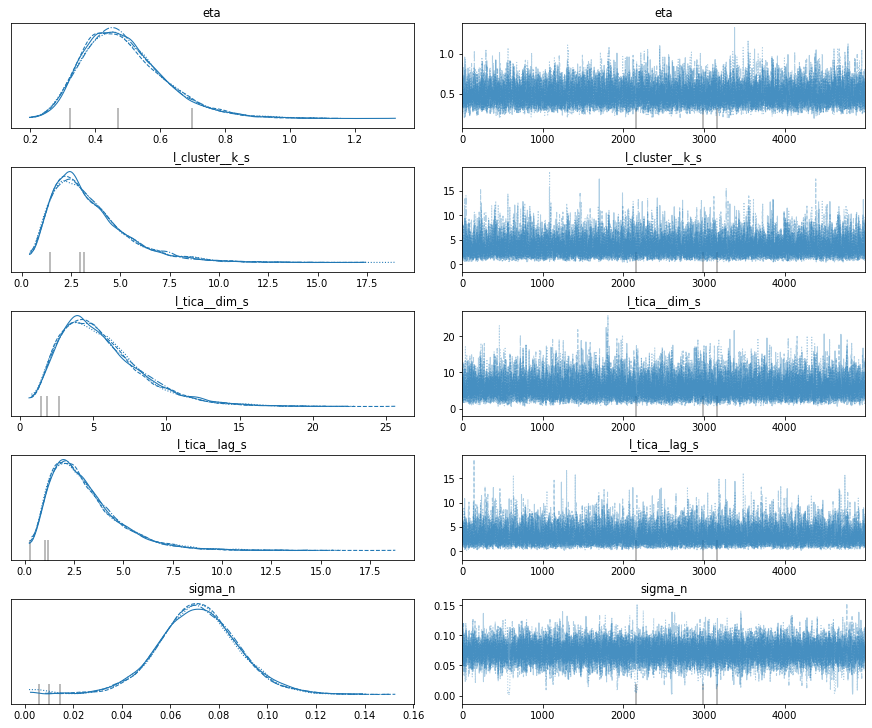

In [164]:
pm.plot_trace(results['trace'])

/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/arviz/plots/pairplot.py:223: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  warnings.warn(


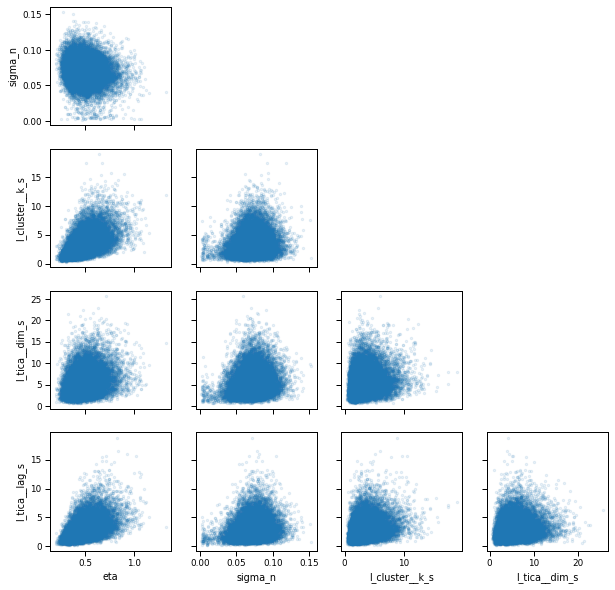

In [192]:
with sns.plotting_context('paper'):
    pm.plots.plot_pair(results['trace'],
                var_names=['eta', 'sigma_n', 'l_cluster__k_s', 'l_tica__dim_s', 'l_tica__lag_s' ],
                kind='scatter',
                divergences=True, figsize=(10, 10), scatter_kwargs={'alpha': 0.1})

In [207]:
data = pd.read_hdf('vamps_and_hps.h5')
# # data['feature'] = data.apply(lambda x: 'dihedrals' if x['feature__value'] == 'dihedrals' else f"{x['feature__value']}_{x['distances__transform']}", axis=1)
data = data.loc[(data.protein=='Chignolin') & (data.feature__value=='dihedrals'), :]


vamps  = data.groupby(['hp_index'], as_index=False)['value'].median()
vamps = vamps.merge(data.loc[:, ['cluster__k', 'tica__dim', 'tica__lag', 'hp_index']].drop_duplicates(), on='hp_index', how='left')
vamps.drop(labels='hp_index', axis=1,  inplace=True)


,value,cluster__k,tica__dim,tica__lag
0,1.869071,191.0,8.0,76.0
1,1.874735,154.0,5.0,2.0
2,1.874913,273.0,2.0,5.0
3,1.860891,249.0,1.0,94.0
4,1.867783,44.0,4.0,14.0


In [208]:
ind_vars = ['cluster__k', 'tica__dim', 'tica__lag']
input_space = {'tica__lag': np.array([1, 10, 100]), 'tica__dim': np.array([1, 5, 10]), 'cluster__k': np.array([10, 250, 500]), 
              'distances__scheme': np.array(['ca', 'closest-heavy'])}


dep_var = list(vamps.columns)[0]
ind_vars = list(vamps.columns)[1:]

formula = f"np.log({dep_var}) ~ 0 + " + ' + '.join(ind_vars)
new_results = fit(vamps, dep_var, ind_vars, formula, input_space, bayes_kws=dict(draws=5000, tune=2000, chains=4, cores=4, target_accept=0.90))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_n, l_tica__lag_s, l_tica__dim_s, l_cluster__k_s, eta]


INFO (theano.gof.compilelock): Waiting for existing lock by process '91644' (I am process '91674')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.0-64/lock_dir
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result e

/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/arviz/plots/pairplot.py:223: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  warnings.warn(


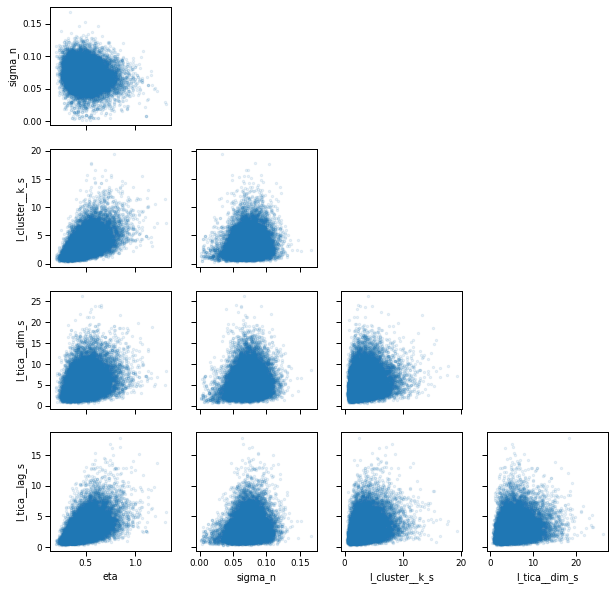

In [209]:
with sns.plotting_context('paper'):
    pm.plots.plot_pair(new_results['trace'],
                var_names=['eta', 'sigma_n', 'l_cluster__k_s', 'l_tica__dim_s', 'l_tica__lag_s' ],
                kind='scatter',
                divergences=True, figsize=(10, 10), scatter_kwargs={'alpha': 0.1})

array([[<AxesSubplot:title={'center':'eta'}>,
        <AxesSubplot:title={'center':'eta'}>],
       [<AxesSubplot:title={'center':'l_cluster__k_s'}>,
        <AxesSubplot:title={'center':'l_cluster__k_s'}>],
       [<AxesSubplot:title={'center':'l_tica__dim_s'}>,
        <AxesSubplot:title={'center':'l_tica__dim_s'}>],
       [<AxesSubplot:title={'center':'l_tica__lag_s'}>,
        <AxesSubplot:title={'center':'l_tica__lag_s'}>],
       [<AxesSubplot:title={'center':'sigma_n'}>,
        <AxesSubplot:title={'center':'sigma_n'}>]], dtype=object)

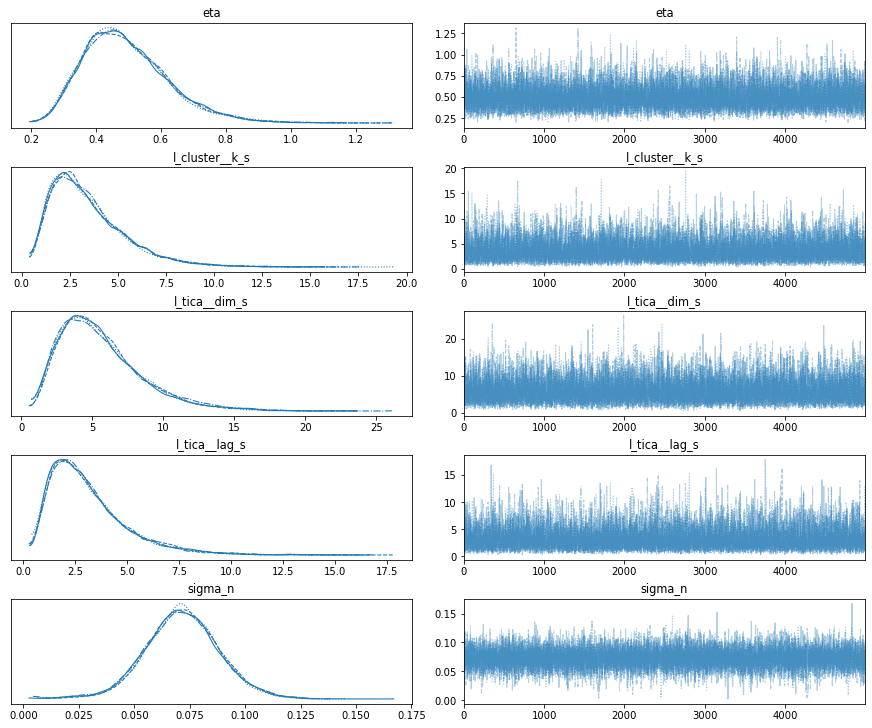

In [210]:
pm.plot_trace(new_results['trace'])

In [212]:
    # determin min/max values for scaling function
    
data = vamps
dep_range = np.array([data[dep_var].min(), data[dep_var].max()])    
output_space = {'dep_var': dep_range}
var_space = input_space.copy()
var_space.update({dep_var: output_space['dep_var']})

# Create scaler
vs = funcs.create_grid(var_space)
vs_y, vs_X = funcs.create_dmatrices(vs, formula=formula)
_, scaler = funcs.scale_dmatrix(pd.concat([vs_y, vs_X], axis=1), scaler=None)

# Scale data
y, X = funcs.create_dmatrices(data, formula=formula)
data_s, _ = funcs.scale_dmatrix(pd.concat([y, X], axis=1), scaler=scaler)

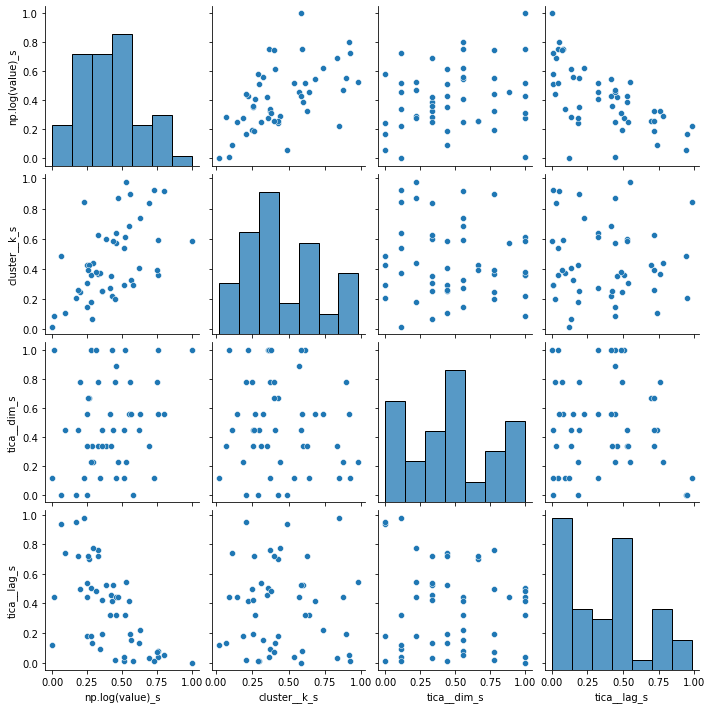

In [213]:
sns.pairplot(data_s)